# Individual Assignment 1
#### (Due on Aug 25 11:59PM)




## Part I: Simulation
In this exercise, we will use simulation to illustrate the variability of statistics calculated from random samples. Suppose there is a normal population of size $N=10000$, with mean $\mu=100$ and standard deviation $\sigma=15$. Now we draw a sample from the population, of size $n=100$ **with replacement**, we can calculate sample statistics such as mean and variance. If we further repeat the sampling process many times, say 200, we will have 200 sets of similar sample statistics. Let’s examine these sample statistics.

The necessary parameters are already set up as below.


In [1]:
pop_size = 10000
pop_mean = 100
pop_sd = 15
num_of_samples = 200
sample_size = 100

### Questions and Answers
1. Use random seed **1234** to conduct the simulation (i.e., simulate the population as specified, draw 200 samples (each of size 100), and calculate sample mean and variance for each sample, respectively), evaluate the mean and standard deviation of the sample statistics, and compare with their theoretical values. Draw histograms of the sample mean and sample variance respectively.

**REMARK 1**: Recall that, according to the Central Limit Theorem, the sample mean 
$$\bar{X} \sim  \text{N}\left(\mu, \frac{\sigma^2}{n} \right).$$

**REMARK 2**: Recall that theoretically, the sample variance $S^2$ satisfies
$$\text{E}[S^2] = \sigma^2, ~~ \text{Var}[S^2] = \frac{2 \sigma^4}{n - 1}, ~~\text{and } \frac{(n-1)S^2}{\sigma^2} \sim \chi^2_{n-1}.$$

Answer: 

In [2]:
import matplotlib.pyplot as plt
def histograms(sample_mean_lst, sample_var_lst, pop_mean, pop_sd, sample_size, is_distribution=True, 
               num_bins = 50, figsize=(14, 5)):
    
    fig = plt.figure(figsize=figsize)
    
    # plot sample mean
    ax1 = plt.subplot(121)
    ax1.hist(sample_mean_lst, num_bins, density=1, label='sample mean')
    ax1.set_xlabel('Sample Mean')
    ax1.set_ylabel('Probability Density')
    ax1.set_title('Histograms of the Sample Mean')
    
    # plot sample variance
    ax2 = plt.subplot(122)
    ax2.hist(sample_var_lst, num_bins, density=1, label='sample variance')
    ax2.set_xlabel('Sample Variance')
    ax2.set_ylabel('Probability Density')
    ax2.set_title('Histograms of the Sample Variance')
    
    if is_distribution:
        # plot theoretical distribution for figure 1
        mu, sigma = pop_mean, pop_sd/(sample_size**0.5)
        x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
        y = norm.pdf(x, loc=mu, scale=sigma)
        ax1.plot(x, y, label='theoretical distribution')
        
        # plot theoretical distribution for figure 2
        df = sample_size - 1
        loc = 0
        scale = (pop_sd**2)/df
        x = np.linspace(chi2.ppf(0.005, df, loc, scale),
                        chi2.ppf(0.995, df, loc, scale), 1000)
        y = chi2.pdf(x, df, loc, scale)
        plt.plot(x, y, label='theoretical distribution')
        
    # set plot details
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    plt.show()

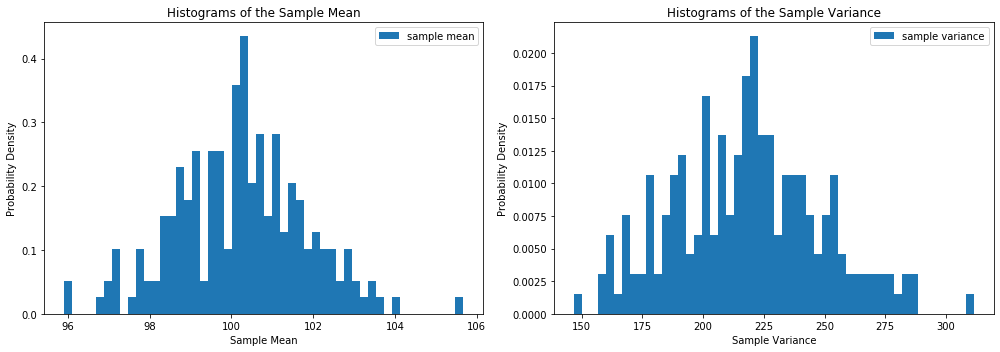

Theoretical mean of the sample mean: 100
Theoretical standard deviation of the sample mean: 1.5
Theoretical mean of the sample variance: 225
Theoretical standard deviation of the sample variance: 31.980107453341567


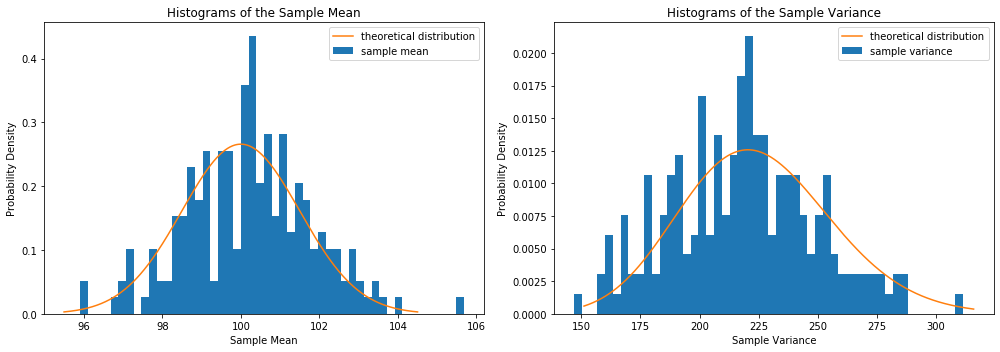

In [3]:
# import package
import numpy as np
from scipy.stats import norm, chi2

# set random seed
np.random.seed(1234)

# simulate the population
random_data = np.random.normal(loc=pop_mean, scale=pop_sd, size=pop_size)

# draw 200 samples and calculate the sample mean and variance for each sample
samples_lst = [np.random.choice(
    random_data, replace=True, size=sample_size) for i in range(num_of_samples)]
sample_mean_lst = [sample.mean() for sample in samples_lst]
sample_var_lst = [sample.var() for sample in samples_lst]

# Draw histograms of the sample mean and sample variance respectively
histograms(sample_mean_lst, sample_var_lst, pop_mean, pop_sd, sample_size, is_distribution = False)

# for comparison, you may just report the theoretical mean/sd of the sample mean and sample variance respectively.
print('Theoretical mean of the sample mean: {}'.format(pop_mean))
print('Theoretical standard deviation of the sample mean: {}'.format(pop_sd/(sample_size**0.5)))

print('Theoretical mean of the sample variance: {}'.format(pop_sd**2))
print('Theoretical standard deviation of the sample variance: {}'.format(np.sqrt((2*pop_sd**4)/(sample_size - 1))))

# overlay the theoretical distribution (not required in the assignment)
histograms(sample_mean_lst, sample_var_lst, pop_mean, pop_sd, sample_size, is_distribution = True)

## Part II: K-Nearest Neighbor Algorithm
### Introduction
In this assignment, we are going to experiment the K-Nearest Neighbor (KNN) algorithm on a higher-dimensional dataset and experience the deterioration of prediction performance as the dimensionality grows.

The experiment is built on top of the 3rd-order polynomial model:
$$y = \beta_0 + \beta_1 * x + \beta_2 * x^2 + \beta_3 * x^3 + \epsilon, ~~ \epsilon \sim \text{N}(0, \sigma^2)$$
and we are going to introduce an extra 20-dimensional predictor $z$, which does NOT actually play a role in generating $y$. Yet, when in estimation, we do not know the fact and will use both $x$ and $z$ as predictors in the KNN algorithm.

### Generation of the high-dimensional dataset
We first simulate the 3rd-order polynomial datasets

In [4]:
import numpy as np
## population parameters
beta0 = 1
beta1 = -2
beta2 = 6
beta3 = -1
sigma = 2

np.random.seed(7890)

## training data
x = np.arange(0, 5, 0.05)
f_x = beta0 + beta1 * x + beta2 * x**2 + beta3 * x**3
epsilon = np.random.normal(loc=0, scale=sigma, size=100)
y = f_x + epsilon

## test data
x_test = np.arange(0, 5.1, 0.1)
f_x_test = beta0 + beta1 * x_test + beta2 * x_test**2 + beta3 * x_test**3
epsilon_test = np.random.normal(loc=0, scale=sigma, size=len(x_test))
y_test = f_x_test + epsilon_test

The resulted training and test dataset have **100** and **51** data points, respectively.

Next, we need to generate $z$, the 20-dimensional predictors, of the same sizes. Each $z$ is a 20-dimensional multivariate normal random variable, with mean being $(0, 0, \ldots, 0)$ and identity covariance matrix (so that the 20 elements are independent standard normal random variables). The resulted $z$ is a 100*20 matrix, with each row being a data point with 20 dimensions.

In [5]:
np.random.seed(7891)
z = np.random.multivariate_normal(size = 100, mean = [0]*20, cov = np.identity(20))
z_test = np.random.multivariate_normal(size = 51, mean = [0]*20, cov = np.identity(20))

Later, we will use $(x, z)$ to predict $y$. Let's first combine $x$ and $z$ into matrices

In [6]:
train_x = np.concatenate((np.expand_dims(x, axis = 1),z),axis = 1)
test_x =  np.concatenate((np.expand_dims(x_test, axis = 1),z_test),axis = 1)


### Questions and Answers

#### 1.	For a fixed $k=15$, fit a KNN model to predict $y$ with $(x, z)$, and measure the training and test MSE. 

Answer: 


In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse

# set fixed parameter
fix_k = 15

# training model
knn = KNeighborsRegressor(n_neighbors=fix_k)
knn.fit(train_x, y)

# predict and measure the performance
y_predict = knn.predict(test_x)
mse_predict = mse(y_test, y_predict)
print(f'Model Performance (MSE): {mse_predict}')

Model Performance (MSE): 32.94639319047726


#### 2.	With the same data, plot the training and test MSE of the KNN model against $k$, and find the optimal $k$ and the corresponding test MSE. 

Answer: 

In [8]:
def plot_k(mse_test, mse_train = False):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(mse_test,  color = 'red',marker = '.', markersize = 8, 
                 markeredgecolor = 'black', markerfacecolor = 'black', label = 'Test MSE')
    if mse_train:
        plt.plot(mse_train,  color = 'blue', marker = '.', markersize = 8, 
             markeredgecolor = 'black', markerfacecolor = 'black',label = 'Train MSE')
    plt.legend()
    plt.title('MSE with different K')
    plt.show()

In [9]:
def train_model(train_x, test_x, y, y_test, is_print = True, is_plot = False):
    k = 0
    # Initialize
    # Parameter 'not_improve': training will stop when performance is not improved for 10 rounds
    optimal_mse, currenct_mse, not_improve = 0,0,0
    mse_lst_train, mse_lst_test = [], []
    while not_improve < 10:
        # set k for this training round
        k += 1
        # train & predict & measure
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_x, y)
        mse_lst_test.append(mse(y_test, knn.predict(test_x)))
        mse_lst_train.append(mse(y, knn.predict(train_x)))
        currenct_mse = mse_lst_test[-1]
        if currenct_mse <= optimal_mse or optimal_mse == 0:
            optimal_mse = currenct_mse
            not_improve = 0
        else:
            not_improve += 1
        if is_print: print(f'Parameter k = {k}; Model Performance (MSE): {currenct_mse}')
    if is_print: print('Performance is not improved for 10 rounds.')
    if is_plot: plot_k(mse_lst_test, mse_lst_train)
    return k - not_improve, optimal_mse

Parameter k = 1; Model Performance (MSE): 76.76871868226493
Parameter k = 2; Model Performance (MSE): 50.63365314897203
Parameter k = 3; Model Performance (MSE): 38.01708840946738
Parameter k = 4; Model Performance (MSE): 34.54505042921676
Parameter k = 5; Model Performance (MSE): 29.643836178903474
Parameter k = 6; Model Performance (MSE): 32.15296586511268
Parameter k = 7; Model Performance (MSE): 33.276044168531136
Parameter k = 8; Model Performance (MSE): 34.63311073505784
Parameter k = 9; Model Performance (MSE): 34.176242162142906
Parameter k = 10; Model Performance (MSE): 34.22440202806502
Parameter k = 11; Model Performance (MSE): 32.63046457909416
Parameter k = 12; Model Performance (MSE): 33.649292293483676
Parameter k = 13; Model Performance (MSE): 35.59585782548111
Parameter k = 14; Model Performance (MSE): 33.41562235237184
Parameter k = 15; Model Performance (MSE): 32.94639319047726
Performance is not improved for 10 rounds.


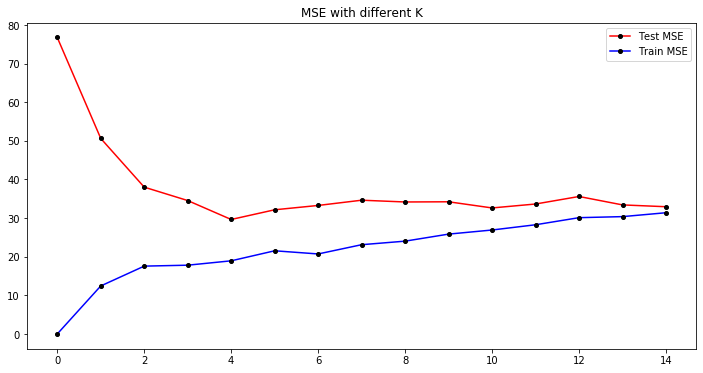

Optimal k: 5
Test MSE: 29.643836178903474


In [10]:
# stop looking for the optimal k when test MSE no longer decreases as k goes up.
k, optimal_mse = train_model(train_x, test_x, y, y_test, is_plot = True)
print(f'Optimal k: {k}\nTest MSE: {optimal_mse}')


#### 3.	Based on the analysis above, compare the above model with $(x, z)$ being the predictors and the previous model with $x$ only. Briefly explain why. 

Answer:






In [11]:
# transfer the x and x_test to 2D array
train_x_only = np.expand_dims(x, axis = 1)
test_x_only =  np.expand_dims(x_test, axis = 1)

In [12]:
k, optimal_mse = train_model(train_x_only, test_x_only, y, y_test)
print(f'Optimal k: {k}\nTest MSE: {optimal_mse}')

Parameter k = 1; Model Performance (MSE): 8.00997691055793
Parameter k = 2; Model Performance (MSE): 5.44808287318148
Parameter k = 3; Model Performance (MSE): 5.426316500001306
Parameter k = 4; Model Performance (MSE): 4.843594490271816
Parameter k = 5; Model Performance (MSE): 4.367417625187504
Parameter k = 6; Model Performance (MSE): 4.93632176506213
Parameter k = 7; Model Performance (MSE): 4.345399813791887
Parameter k = 8; Model Performance (MSE): 4.584586639952677
Parameter k = 9; Model Performance (MSE): 4.500262203638205
Parameter k = 10; Model Performance (MSE): 4.54648828737431
Parameter k = 11; Model Performance (MSE): 4.695587787121037
Parameter k = 12; Model Performance (MSE): 4.833644395839394
Parameter k = 13; Model Performance (MSE): 4.664975361381074
Parameter k = 14; Model Performance (MSE): 4.940785220790044
Parameter k = 15; Model Performance (MSE): 5.022177033161812
Parameter k = 16; Model Performance (MSE): 5.1323236033672055
Parameter k = 17; Model Performance 

##### Explaination: Curse of Dimensionality

 -  The distance between neighbors is dominated by a large number of unrelated attributes.
 -  In this case, instances whose values of two related attributes are consistent may be far apart in the 20-dimensional space.
 -  As the result, relying on the similarity measure of these 20 attributes can mislead the k-nearest neighbor algorithm.

#### 4.	We have seen that the test MSE is significantly worse than what we had without using predictor $z$. To better understand the impact of including irrelevant predictors in the KNN algorithm, let's try to include the 20 dimensions of $z$ one by one. So in each round $j$, we construct the predictors by combining $x$ and the first $j$ columns of $z$, then repeat the analysis in Question 2 and find the optimal $k$ and test MSE. At the end, plot the optimal MSE agaist $j$, and interpret the result. 

Answer: 

In [13]:
def plot_rounds(optimal_mse_lst):
    fig = plt.figure(figsize=(12, 6))
    x = [str(i) for i in range(len(optimal_mse_lst))]
    plt.plot(x, optimal_mse_lst,  color = 'red',marker = '.', markersize = 8, 
             markeredgecolor = 'black', markerfacecolor = 'black', label = 'Test MSE')
    plt.legend()
    plt.title('MSE with Different Number of Redundant Columns')
    plt.show()

Add first 0 columns 	 Optimal k: 7 	 Test MSE: 4.345399813791887
Add first 1 columns 	 Optimal k: 5 	 Test MSE: 7.2142500345041976
Add first 2 columns 	 Optimal k: 14 	 Test MSE: 11.961788211788564
Add first 3 columns 	 Optimal k: 11 	 Test MSE: 14.854589640881168
Add first 4 columns 	 Optimal k: 7 	 Test MSE: 15.78371528304405
Add first 5 columns 	 Optimal k: 4 	 Test MSE: 17.400790194657528
Add first 6 columns 	 Optimal k: 6 	 Test MSE: 20.670086059135617
Add first 7 columns 	 Optimal k: 5 	 Test MSE: 22.42699951576807
Add first 8 columns 	 Optimal k: 4 	 Test MSE: 23.52269690244068
Add first 9 columns 	 Optimal k: 8 	 Test MSE: 24.642352439593413
Add first 10 columns 	 Optimal k: 7 	 Test MSE: 23.370264787676305
Add first 11 columns 	 Optimal k: 6 	 Test MSE: 21.906956923650522
Add first 12 columns 	 Optimal k: 7 	 Test MSE: 23.92850599971722
Add first 13 columns 	 Optimal k: 10 	 Test MSE: 26.650313975995278
Add first 14 columns 	 Optimal k: 10 	 Test MSE: 22.59852873722149
Add fir

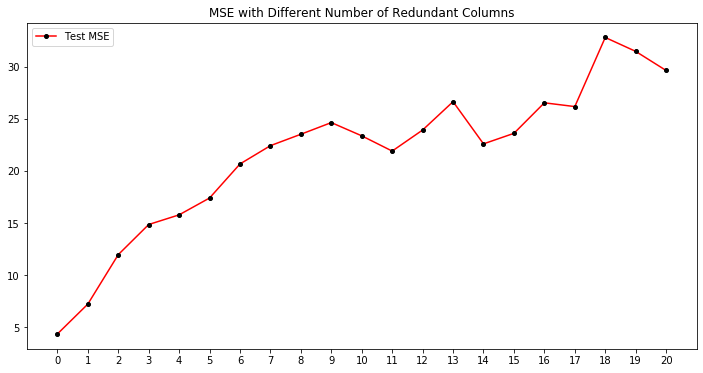

In [14]:
optimal_mse_lst = []
for j in range(len(z[0]) + 1):
    train_x_incremental = np.concatenate(
        (np.expand_dims(x, axis=1), z[:, :j]), axis=1)
    test_x_incremental = np.concatenate(
        (np.expand_dims(x_test, axis=1), z_test[:, :j]), axis=1)
    k, optimal_mse = train_model(
        train_x_incremental, test_x_incremental, y, y_test, is_print=False)
    optimal_mse_lst.append(optimal_mse)
    print(
        f'Add first {j} columns \t Optimal k: {k} \t Test MSE: {optimal_mse}')
plot_rounds(optimal_mse_lst)

##### Explaination: Curse of Dimensionality

 -  Result basically follows: the more unrelated dimensions added, the worse the model's performance. 
 -  The KNN's rationale is that using sample's neighbours(using distance to measure) to represent itself in that similar samples are more likely to be the same category.
 -  The above result shows that unrelated dimensions undermine the process of defining the neighbor, in other words, the similarity between samples is more difficult to describe with distance.